# TAU Vehicle type Recognition
1. TPU 
2. tf.dataset with TFRecord Data Pipeline
3. Keras Model
4. Transfer Learning with Xception Model
5. Model Evaluation
6. Tensorflow Lite Inference
7. Dataset: https://www.kaggle.com/c/vehicle
There are total 17 classes, I worked on 5 classes Bus, Car, Motorcycle,Bicycle and Taxi.

In [ ]:
from google.colab import auth
auth.authenticate_user()

## Connect to Google Cloud Storage

In [ ]:
!curl https://sdk.cloud.google.com | bash

Streaming output truncated to the last 5000 lines.
google-cloud-sdk/lib/surface/meta/cache/list.py
google-cloud-sdk/lib/surface/meta/cli_trees/__init__.py
google-cloud-sdk/lib/surface/meta/cli_trees/list.py
google-cloud-sdk/lib/surface/meta/cli_trees/update.py
google-cloud-sdk/lib/surface/meta/debug.py
google-cloud-sdk/lib/surface/meta/gcloud_command_vocabulary.txt
google-cloud-sdk/lib/surface/meta/generate_command.py
google-cloud-sdk/lib/surface/meta/generate_help_docs.py
google-cloud-sdk/lib/surface/meta/lint.py
google-cloud-sdk/lib/surface/meta/list_commands.py
google-cloud-sdk/lib/surface/meta/list_files_for_upload.py
google-cloud-sdk/lib/surface/meta/list_from_json.py
google-cloud-sdk/lib/surface/meta/list_gcloud.py
google-cloud-sdk/lib/surface/meta/render_markdown.py
google-cloud-sdk/lib/surface/meta/resources/__init__.py
google-cloud-sdk/lib/surface/meta/resources/generate.py
google-cloud-sdk/lib/surface/meta/resources/parse.py
google-cloud-sdk/lib/surface/meta/test.py
google-cl

In [ ]:
!gcloud init

Welcome! This command will take you through the configuration of gcloud.

Settings from your current configuration [default] are:
component_manager:
  disable_update_check: 'True'
compute:
  gce_metadata_read_timeout_sec: '0'
core:
  account: saliha.mehboob@sjsu.edu

Pick configuration to use:
 [1] Re-initialize this configuration [default] with new settings 
 [2] Create a new configuration
Please enter your numeric choice:  1

Your current configuration has been set to: [default]

You can skip diagnostics next time by using the following flag:
  gcloud init --skip-diagnostics

Network diagnostic detects and fixes local network connection issues.
Reachability Check passed.
Network diagnostic passed (1/1 checks passed).

Choose the account you would like to use to perform operations for 
this configuration:
 [1] saliha.mehboob@sjsu.edu
 [2] Log in with a new account
Please enter your numeric choice:  1

You are logged in as: [saliha.mehboob@sjsu.edu].

Pick cloud project to use: 
 [1] c

## Mount Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


### Copy Data from Google drive to GCS

In [ ]:
!gsutil cp -r /content/gdrive/MyDrive/homework1/train_tfrecords gs://cmpe249/

Copying file:///content/gdrive/MyDrive/homework1/train_tfrecords/train.tfrecords-000 [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copying file:///content/gdrive/MyDrive/homework1/train_tfrecords/train.tfrecords-001 [Content-Type=application/octet-stream]...
Copying file:///content/gdrive/MyDrive/homework1/train_tfrecords/tra

In [ ]:
!gsutil cp -r /content/gdrive/MyDrive/homework1/test_dir/ gs://cmpe249/

Copying file:///content/gdrive/MyDrive/homework1/test_dir/000142.jpg [Content-Type=image/jpeg]...
Copying file:///content/gdrive/MyDrive/homework1/test_dir/testset/000006.jpg [Content-Type=image/jpeg]...
Copying file:///content/gdrive/MyDrive/homework1/test_dir/testset/000009.jpg [Content-Type=image/jpeg]...
Copying file:///content/gdrive/MyDrive/homework1/test_dir/testset/000013.jpg [Content-Type=image/jpeg]...
\ [4 files][  1.4 MiB/  1.4 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file:///content/gdrive/MyDrive/homework1/test_dir/testset/000015.jpg [Content-Type=image/jpeg]...
Copying file:///content/gdrive/MyDrive/homework1/test_dir/testset/000022.jpg [Content-Type=image/jpeg]...
Copying file:///content/gdrive/MyDrive/

In [ ]:
import os
import tensorflow as tf
from PIL import Image 
from tensorflow.keras import layers,Input
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray
from functools import partial
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128 # as data is imbalanced therefore bigger batch size
IMAGE_SIZE = [180, 180]
keys = [str(i) for i in list(range(0,3))]
values = ['Bus','Car','Motorcycle']
classes = dict(zip(keys,values))

# Enable and Check TPUs

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Device:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

Device: grpc://10.34.237.194:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.34.237.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.34.237.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of replicas: 8


## Check Tensorflow and Keras version (should be >2.0)

In [ ]:
print("Tensorflow Version: ", tf.__version__)
print("Keras Version: ", tf.keras.__version__)

Tensorflow Version:  2.4.1
Keras Version:  2.4.0


In [ ]:
GCS_PATTERN = 'gs://cmpe249'
cwd = '/content/gdrive/MyDrive/homework1/data_dir/train'
DATA_SIZE = len(list(pathlib.Path(cwd).glob('*/*.jpg')))

# Reading TF Records from Google CLoud Storage

In [ ]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, IMAGE_SIZE)
    return image
    
def read_tfrecord(example, labeled):
    tfrecord_format = (
        {
            "image": tf.io.FixedLenFeature([], tf.string),
            "target": tf.io.FixedLenFeature([], tf.int64),
        }
        if labeled
        else {"image": tf.io.FixedLenFeature([], tf.string),}
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image"])
    if labeled:
        label = tf.cast(example["target"], tf.int64)
        #label = tf.one_hot(target, 3)
        return image, label
    return image

## Load Dataset

In [ ]:
def load_dataset(filenames, labeled=True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    ) 
    dataset = dataset.with_options(
        ignore_order
    ) 
    dataset = dataset.map(
        partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset
def get_dataset(filenames, labeled=True):
    dataset = load_dataset(filenames, labeled=labeled)
    return dataset
# dataset piepline to increease the performance
def configure_for_performance(dataset):
    dataset= dataset.cache()
    dataset = dataset.shuffle(buffer_size=DATA_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

## Create Dataset

In [ ]:
FILENAMES = tf.io.gfile.glob(GCS_PATTERN + "/train_tfrecords/train.tfrec*")
dataset = get_dataset(FILENAMES) # get the whole dataset

In [ ]:
FILENAMES

['gs://cmpe249/train_tfrecords/train.tfrecords-000',
 'gs://cmpe249/train_tfrecords/train.tfrecords-001',
 'gs://cmpe249/train_tfrecords/train.tfrecords-002',
 'gs://cmpe249/train_tfrecords/train.tfrecords-003',
 'gs://cmpe249/train_tfrecords/train.tfrecords-004',
 'gs://cmpe249/train_tfrecords/train.tfrecords-005']

In [ ]:
# Splitting dataset into train and validation set
train_size = int(0.8 * DATA_SIZE)   # 80% data for training
val_size = int(0.2 * DATA_SIZE)
dataset = dataset.shuffle(buffer_size = DATA_SIZE)
train_dataset = dataset.take(train_size)
valid_dataset = dataset.skip(train_size)
train_dataset = configure_for_performance(train_dataset)
valid_dataset = configure_for_performance(valid_dataset)

## Visualize Dataset

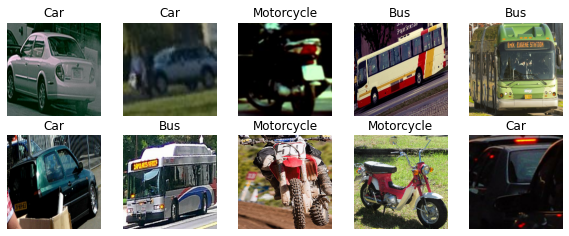

In [ ]:
# verify datasets

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(10):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255.0)
        plt.title(classes.get(str(label_batch[n])))
        plt.axis("off")
image_batch, label_batch = next(iter(train_dataset))
show_batch(image_batch,label_batch.numpy())

# Keras Sequential Model 

In [ ]:
from tensorflow.keras import layers,Input
num_classes = 3

keras_model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
keras_model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

## Train the Model

In [ ]:
history_keras = keras_model.fit(
train_dataset,
  validation_data=valid_dataset,
  epochs=10
)

Epoch 1/10
75/75 [==============================] - 35s 462ms/step - loss: 1.0375 - accuracy: 0.5488 - val_loss: 0.5562 - val_accuracy: 0.7899
Epoch 2/10
75/75 [==============================] - 26s 348ms/step - loss: 0.4955 - accuracy: 0.8095 - val_loss: 0.4276 - val_accuracy: 0.8303
Epoch 3/10
75/75 [==============================] - 26s 348ms/step - loss: 0.3777 - accuracy: 0.8528 - val_loss: 0.3304 - val_accuracy: 0.8702
Epoch 4/10
75/75 [==============================] - 26s 348ms/step - loss: 0.2989 - accuracy: 0.8839 - val_loss: 0.2800 - val_accuracy: 0.8895
Epoch 5/10
75/75 [==============================] - 26s 348ms/step - loss: 0.2501 - accuracy: 0.9062 - val_loss: 0.2436 - val_accuracy: 0.9055
Epoch 6/10
75/75 [==============================] - 26s 348ms/step - loss: 0.1942 - accuracy: 0.9319 - val_loss: 0.1927 - val_accuracy: 0.9265
Epoch 7/10
75/75 [==============================] - 26s 346ms/step - loss: 0.1390 - accuracy: 0.9533 - val_loss: 0.1542 - val_accuracy: 0.9563

## Visualize the Accuracy and Loss Metrics

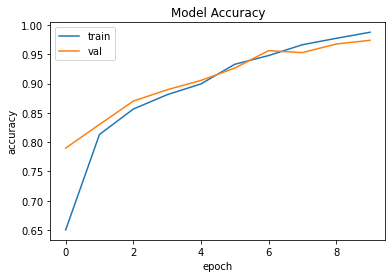

In [ ]:
plt.plot(history_keras.history['accuracy'])
plt.plot(history_keras.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

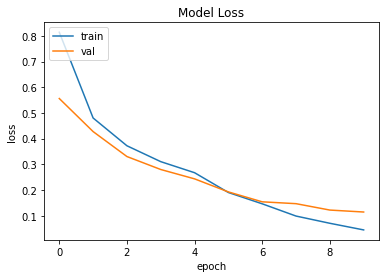

In [ ]:
plt.plot(history_keras.history['loss'])
plt.plot(history_keras.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evaluate the Model (on Test Dataset)

In [ ]:
test_images = tf.io.gfile.glob(GCS_PATTERN + '/test_dir/testset/*.jpg')
len(test_images)

20

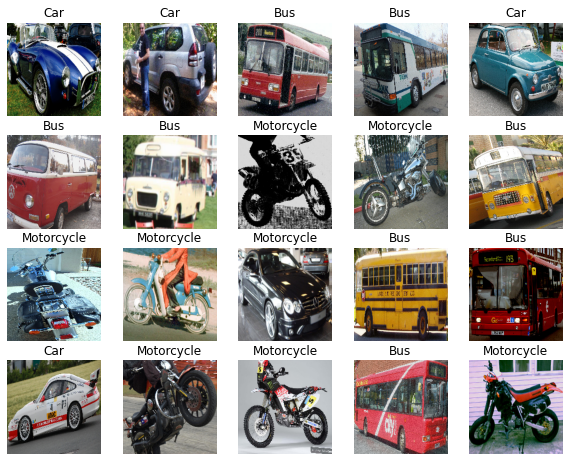

In [ ]:
twd='/content/gdrive/MyDrive/homework1/test_dir/testset'
test_dir = pathlib.Path(twd)
images = list(test_dir.glob('*.jpg'))

class_names=[0,1,2]
plt.figure(figsize=(10, 10))
for i in range(len(images)):
   
    img = tf.keras.preprocessing.image.load_img(
        images[i], target_size=(180, 180)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = keras_model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    img_class = class_names[np.argmax(score)]
    plt.title(classes.get(str(img_class)))
    plt.axis("off")

# Save the Model

In [ ]:
keras_model.save(GCS_PATTERN+'/saved_models/my_model/', save_format='tf')

INFO:tensorflow:Assets written to: gs://cmpe249/saved_models/my_model/assets


INFO:tensorflow:Assets written to: gs://cmpe249/saved_models/my_model/assets


# Tensorflow Xception Model

In [ ]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=20, decay_rate=0.96, staircase=True
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "vehicles_model.h5", save_best_only=True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

## Transfer Learning (Base Model = Imagenet)

In [ ]:
def make_model():
    base_model = tf.keras.applications.Xception(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet"
    )

    base_model.trainable = False

    inputs = tf.keras.layers.Input([*IMAGE_SIZE, 3])
    x = tf.keras.applications.xception.preprocess_input(inputs)
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    outputs = tf.keras.layers.Dense(3, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )

    return model

## Train the Model

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
with strategy.scope():
    model = make_model()

history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=valid_dataset,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/5
75/75 [==============================] - 19s 123ms/step - loss: 0.3349 - accuracy: 0.8676 - val_loss: 0.0617 - val_accuracy: 0.9811
Epoch 2/5
75/75 [==============================] - 4s 51ms/step - loss: 0.0926 - accuracy: 0.9731 - val_loss: 0.0513 - val_accuracy: 0.9836
Epoch 3/5
75/75 [==============================] - 4s 51ms/step - loss: 0.0763 - accuracy: 0.9767 - val_loss: 0.0495 - val_accuracy: 0.9857
Epoch 4/5
75/75 [==============================] - 4s 52ms/step - loss: 0.0684 - accuracy: 0.9794 - val_loss: 0.0477 - val_accuracy: 0.9853
Epoch 5/5
75/75 [==============================] - 4s 51ms/step - loss: 0.0643 - accuracy: 0.9796 - val_loss: 0.0437 - val_accuracy: 0.9870


## Visualize the Model Metrics

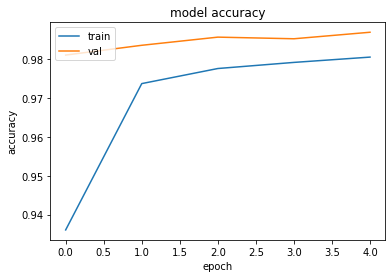

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

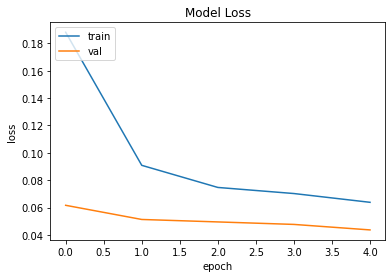

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evaluate the Model (on Test Dataset)

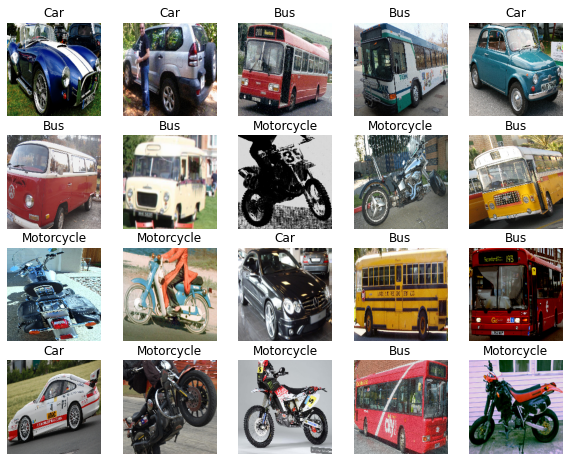

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(len(images)):
   
    img = tf.keras.preprocessing.image.load_img(
        images[i], target_size=(180, 180)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array) #xception model
    score = tf.nn.softmax(predictions[0])
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    img_class = class_names[np.argmax(score)]
    plt.title(classes.get(str(img_class)))
    plt.axis("off")

# TFLite Inference

ref: https://www.tensorflow.org/lite/guide/get_started https://www.tensorflow.org/lite/guide/inference#load_and_run_a_model_in_python

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tflite_model = converter.convert()
# Save the model.
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp173adbon/assets


INFO:tensorflow:Assets written to: /tmp/tmp173adbon/assets


In [ ]:
saved_model_dir = GCS_PATTERN+'/saved_models/my_model/'
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

6636252

In [ ]:
!ls

adc.json		gdrive	      sample_data
converted_model.tflite	model.tflite  saved_model


In [ ]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="converted_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']

In [ ]:
input_shape

array([  1, 180, 180,   3], dtype=int32)

In [ ]:
output_details

[{'dtype': numpy.float32,
  'index': 20,
  'name': 'StatefulPartitionedCall:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([1, 3], dtype=int32),
  'shape_signature': array([-1,  3], dtype=int32),
  'sparsity_parameters': {}}]

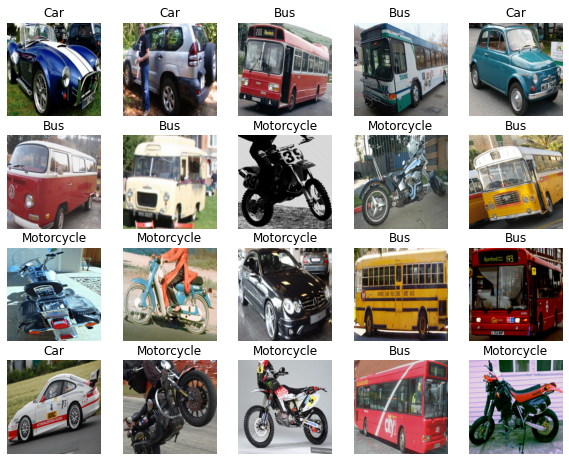

In [ ]:
# predictions on test data using tflite
twd='/content/gdrive/MyDrive/homework1/test_dir/testset'
test_dir = pathlib.Path(twd)
images = list(test_dir.glob('*.jpg'))
plt.figure(figsize=(10, 10))
for i in range(len(images)):
  image = Image.open(images[i]).resize((180, 180))
  image = np.array(image)
  input=image[np.newaxis, ...]
  input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
  input_data.shape
  input_data = np.array(input, dtype=np.float32)
  interpreter.set_tensor(input_details[0]['index'], input_data)

  interpreter.invoke() # tf lite

  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  output_data = interpreter.get_tensor(output_details[0]['index'])
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(image)
  plt.title(classes.get(str(class_names[np.argmax(output_data)])))
  plt.axis("off")
